In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scrublet as scr
import celltypist
from celltypist import models
import decoupler as dc
import matplotlib.pyplot as plt
import seaborn as sns
sc.set_figure_params(dpi=150)

# Import raw files

In [2]:
inpath="/home/lugli/spuccio/Projects/SP039/FileH5AD_input/"

In [3]:
G620_T = sc.read(inpath+"G620_T.h5ad")
G945_T = sc.read(inpath+"G945_T.h5ad")
G946_T = sc.read(inpath+"G946_T.h5ad")
G910_T = sc.read(inpath+"G910_T.h5ad")
G967_T = sc.read(inpath+"G967_T.h5ad")
G983_T = sc.read(inpath+"G983_T.h5ad")
G1003_T = sc.read(inpath+"G1003_T.h5ad")

# Read Metadata

In [4]:
metadata = pd.read_excel('Metadata2.xlsx')

In [5]:
metadata['Sample'] =   [ 'Patient' + str(col) for col in metadata.Sample]

In [6]:
G620_T.shape

(911, 17419)

In [7]:
G945_T.shape

(4912, 17419)

In [8]:
G946_T.shape

(3722, 17419)

In [9]:
G910_T.shape

(8231, 17419)

In [10]:
G967_T.shape

(11264, 17419)

In [11]:
G983_T.shape

(6101, 17419)

In [12]:
G1003_T.shape

(9571, 17419)

# Fix Metadata 

In [13]:
def fixmeta(metadata,sample,adata):
    tmp1 = metadata.loc[metadata['SampleID'] == sample].loc[metadata.loc[metadata['SampleID'] == sample].index.repeat(adata.shape[0])]
    tmp1.reset_index(drop=True,inplace=True)
    tmp1.set_index( sample+"_"  + tmp1.index.astype(str),inplace=True) 
    adata.obs = tmp1
    return adata

In [14]:
G620_T = fixmeta(metadata,"G620_T",G620_T)
G945_T = fixmeta(metadata,"G945_T",G945_T)
G946_T = fixmeta(metadata,"G946_T",G946_T)
G910_T = fixmeta(metadata,"G910_T",G910_T)
G967_T = fixmeta(metadata,"G967_T",G967_T)
G983_T = fixmeta(metadata,"G983_T",G983_T)
G1003_T = fixmeta(metadata,"G1003_T",G1003_T)



# Concatenate 

In [15]:
G620_T.var_names_make_unique()
G945_T.var_names_make_unique()
G946_T.var_names_make_unique()
G910_T.var_names_make_unique()
G967_T.var_names_make_unique()
G983_T.var_names_make_unique()
G1003_T.var_names_make_unique()

In [16]:
adata = G620_T.concatenate(G945_T,G946_T,G910_T,G967_T,G983_T,G1003_T,
                         index_unique=None)

In [18]:
del(G620_T,G945_T,G946_T,G910_T,G967_T,G983_T,G1003_T)

In [19]:
print(adata.obs['SampleID'].value_counts())
adata

G967_T     11264
G1003_T     9571
G910_T      8231
G983_T      6101
G945_T      4912
G946_T      3722
G620_T       911
Name: SampleID, dtype: int64


AnnData object with n_obs × n_vars = 44712 × 17419
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch'

In [20]:
adata.layers['raw'] = adata.X 

# Calculate QC

In [21]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

In [22]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

In [23]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mt2'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [24]:
adata

AnnData object with n_obs × n_vars = 44712 × 17419
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'raw'

# Plot QC

... storing 'SampleID' as categorical
... storing 'GEO_RNA' as categorical
... storing 'Cohort' as categorical
... storing 'Type' as categorical
... storing 'Subtype' as categorical
... storing 'Diagnosis' as categorical
... storing 'Grade' as categorical
... storing 'Location' as categorical
... storing 'IDH1_Status' as categorical
... storing 'EGFR_Status' as categorical
... storing 'MGMT' as categorical
... storing 'Sample' as categorical
... storing 'Sex' as categorical
... storing 'Age' as categorical
... storing 'Sorted' as categorical
... storing 'MET' as categorical


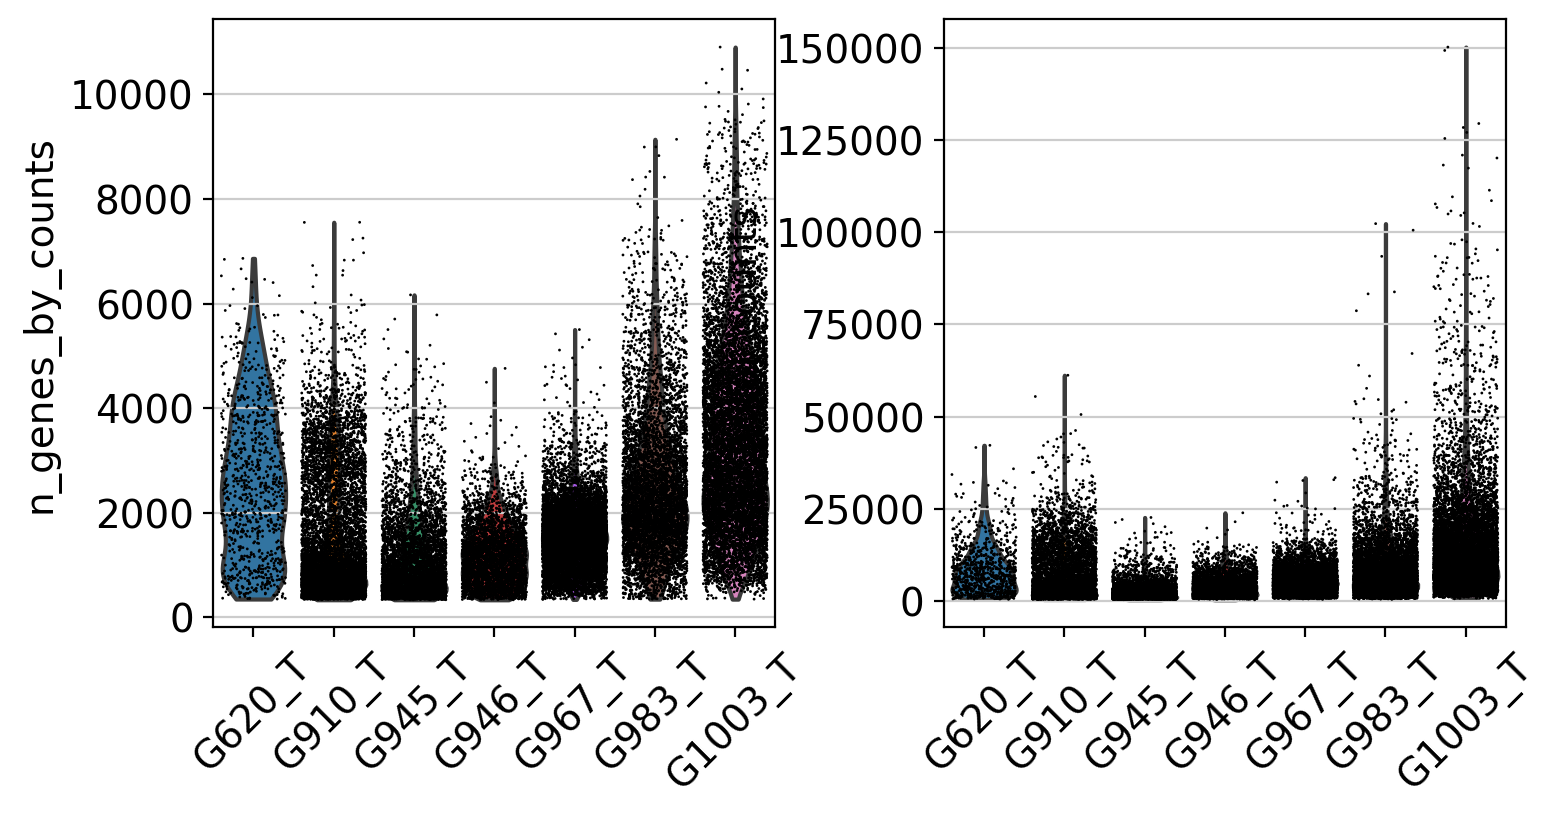

In [25]:
sc.set_figure_params(dpi=100)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

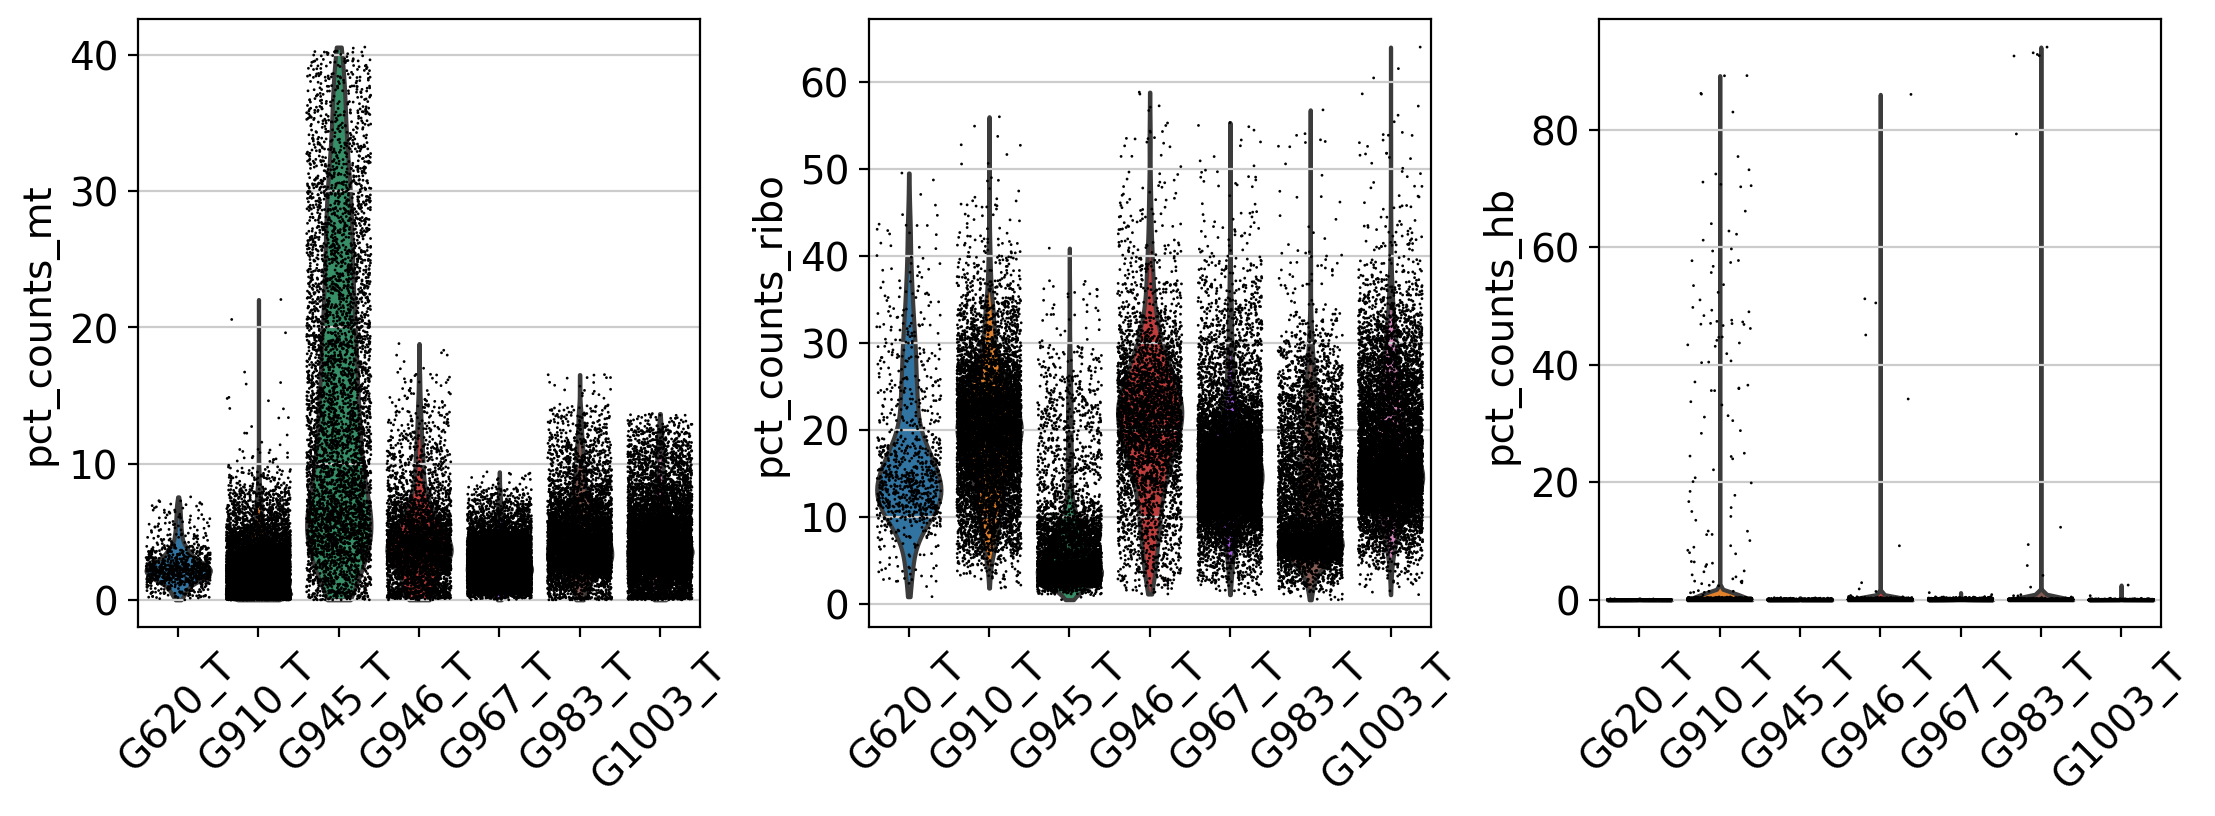

In [26]:
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

In [27]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="SampleID")

# Filtering

In [28]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

44712 17419


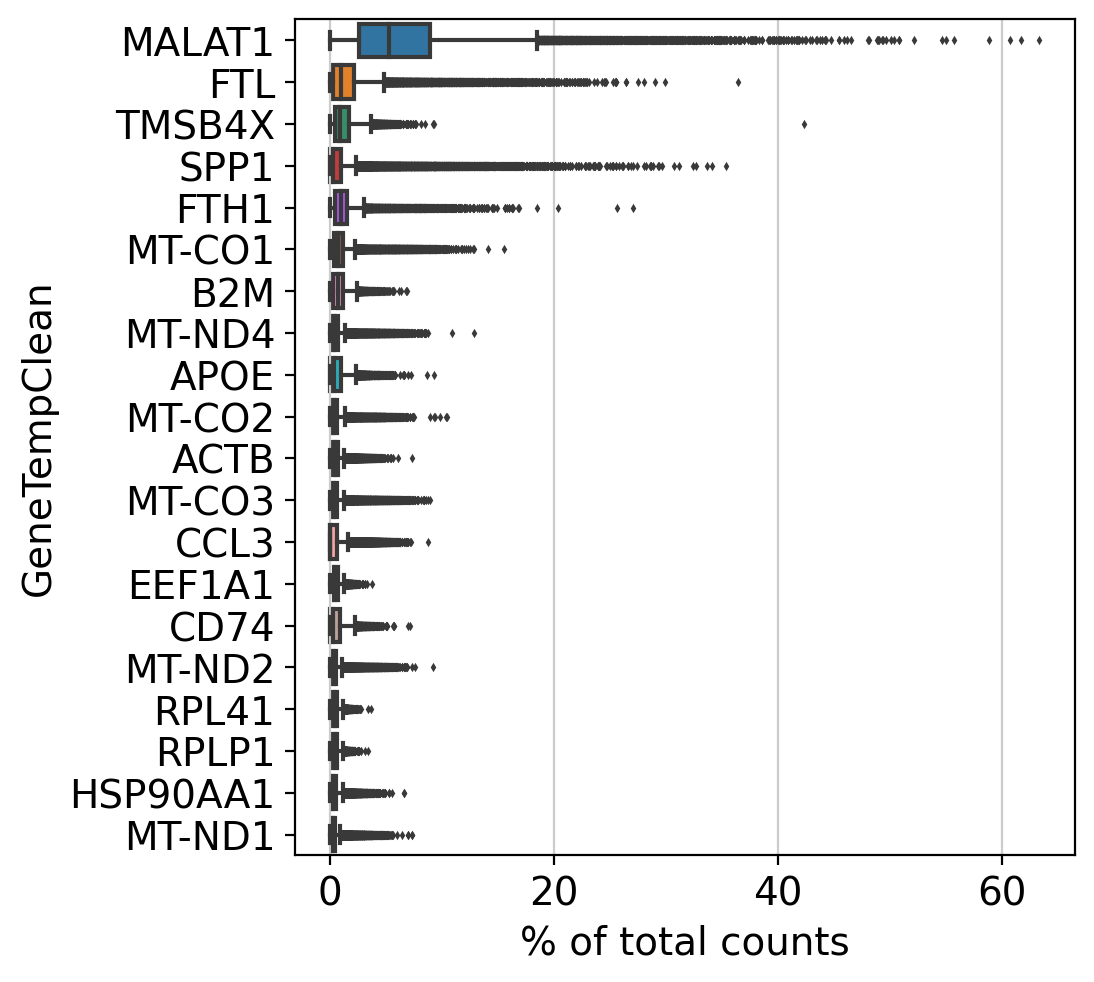

In [29]:
sc.pl.highest_expr_genes(adata, n_top=20)

# Mito/Ribo filtering

In [30]:
adata = adata[adata.obs['pct_counts_mt'] < 20, :]

# filter for percent ribo > 0.05
adata = adata[adata.obs['pct_counts_ribo'] > 2, :]
adata = adata[adata.obs['pct_counts_hb'] < 2, :]
print("Remaining cells %d"%adata.n_obs)

Remaining cells 42927


# Plot filtered QC

In [31]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

In [33]:
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

# Filter genes

In [34]:
mito_gene_names = sc.queries.mitochondrial_genes("hsapiens")

In [35]:
mito_gene_indicator = np.in1d(adata.var_names, mito_gene_names)

In [36]:
adata = adata[:, ~mito_gene_indicator]

In [37]:
print(adata.n_obs, adata.n_vars)
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
ribo_genes = adata.var_names.str.startswith(("RPL","RPS"))
hb_genes = adata.var_names.str.contains('^HB[^(P)]')

remove = np.add(ribo_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

42927 17406
42927 17301


# Calculate cell-cycle scores

In [38]:
cell_cycle_genes = [x.strip() for x in open('/home/lugli/spuccio/Projects/SP035_TregIntegration/Analysis/regev_lab_cell_cycle_genes_homo.txt')]
print(len(cell_cycle_genes))
# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

90
89


In [39]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

... storing 'phase' as categorical


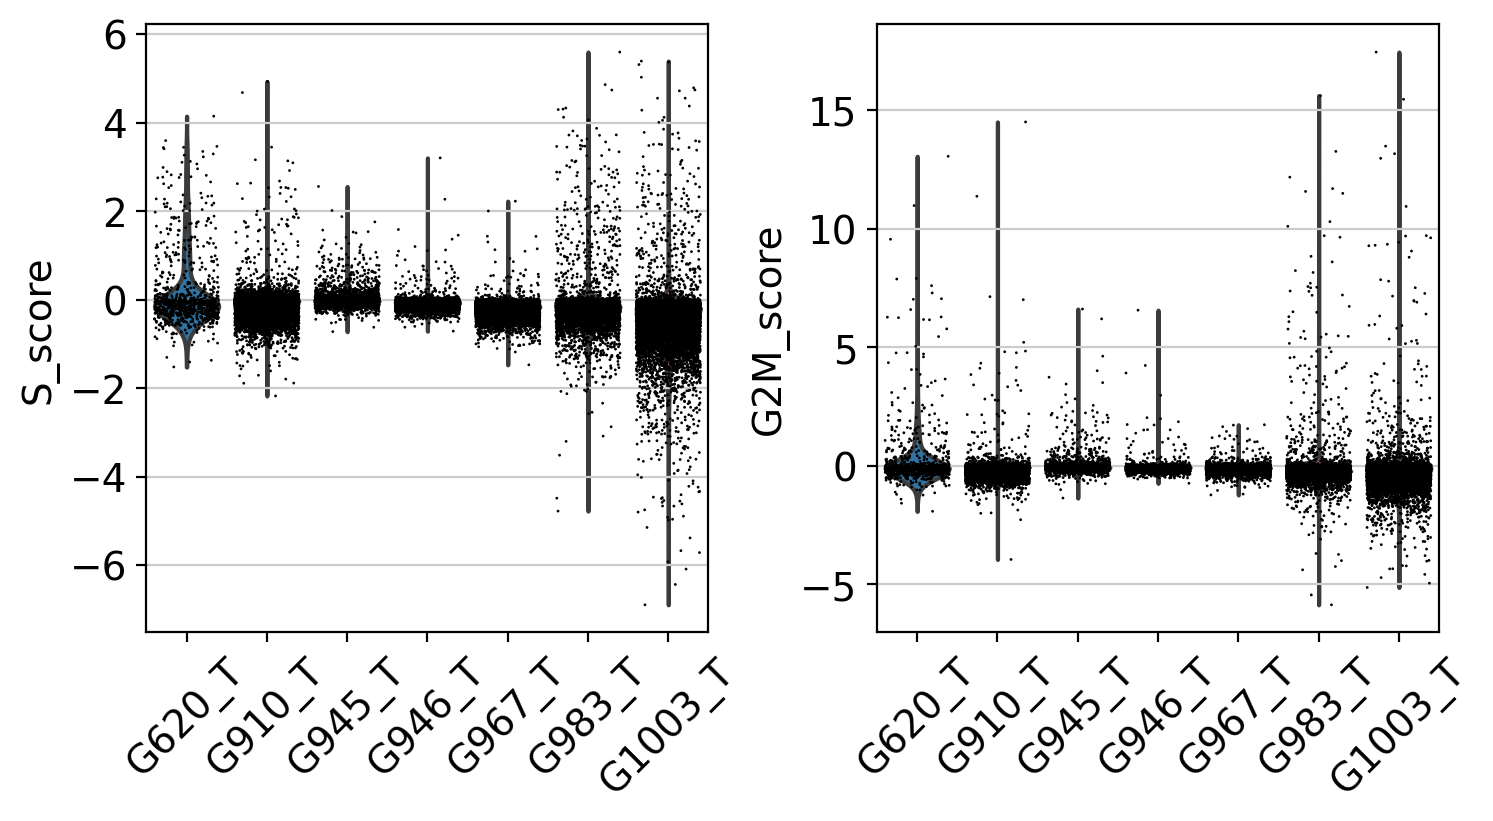

In [40]:
sc.pl.violin(adata, ['S_score', 'G2M_score'],
             jitter=0.4, groupby = 'SampleID', rotation=45)

# Predict doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 21.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.2%
Elapsed time: 60.3 seconds


108

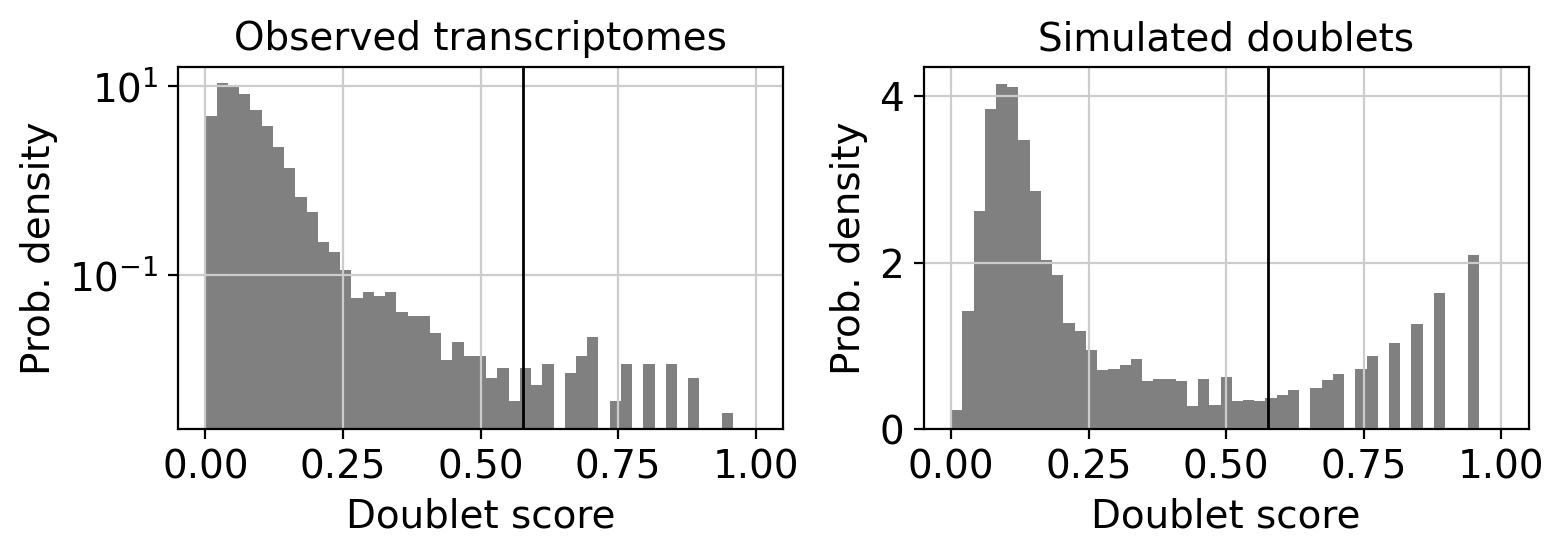

In [41]:
scrub = scr.Scrublet(adata.layers['raw'])
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs['predicted_doublets'])

In [42]:
# add in column with singlet/doublet instead of True/False
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

In [43]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby = 'doublet_info', rotation=45)

... storing 'doublet_info' as categorical


In [44]:
adata = adata[adata.obs['doublet_info'] == "False",:]

# Processing 

In [45]:
#adata = adata[adata.obs.n_genes_by_counts < 3000, :]
# save normalized counts in raw slot.
adata.raw = adata
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
adata.layers['cpm'] = adata.X
# logaritmize
sc.pp.log1p(adata)
adata.layers['log1p'] = adata.X
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# Filter higly variable genes
#adata.raw = adata

# scale
#sc.pp.scale(adata)

# Celltypist classification

In [46]:
sc.tl.pca(adata,svd_solver='arpack',copy=False)

In [47]:
sc.pp.neighbors(adata,n_neighbors=10, n_pcs=40)

In [48]:
sce.pp.harmony_integrate(adata, ['SampleID'])

2022-06-16 15:59:24,955 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2022-06-16 15:59:33,153 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2022-06-16 15:59:41,433 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2022-06-16 15:59:49,713 - harmonypy - INFO - Converged after 3 iterations
Converged after 3 iterations


In [49]:
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_pca_harmony')

In [50]:
sc.tl.umap(adata)

In [51]:
adata.obsm['X_umap_harmony'] = adata.obsm['X_umap']

In [52]:
adata

AnnData object with n_obs × n_vars = 42819 × 17301
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony'
    varm: 'PCs'
    layers: 'raw', 'cpm', 'log1p'
    obsp: 'distances', 'connectivities'

In [53]:
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 14
📂 Storing models in /home/lugli/spuccio/.celltypist/data/models
💾 Downloading model [1/14]: Immune_All_Low.pkl
💾 Downloading model [2/14]: Immune_All_High.pkl
💾 Downloading model [3/14]: Immune_All_PIP.pkl
💾 Downloading model [4/14]: Immune_All_AddPIP.pkl
💾 Downloading model [5/14]: Adult_Mouse_Gut.pkl
💾 Downloading model [6/14]: COVID19_Immune_Landscape.pkl
💾 Downloading model [7/14]: Cells_Fetal_Lung.pkl
💾 Downloading model [8/14]: Cells_Intestinal_Tract.pkl
💾 Downloading model [9/14]: Cells_Lung_Airway.pkl
💾 Downloading model [10/14]: Developing_Mouse_Brain.pkl
💾 Downloading model [11/14]: Healthy_COVID19_PBMC.pkl
💾 Downloading model [12/14]: Human_Lung_Atlas.pkl
💾 Downloading model [13/14]: Nuclei_Lung_Airway.pkl
💾 Downloading model [14/14]: Pan_Fetal_Human.pkl


In [54]:
model = models.Model.load(model = 'Immune_All_High.pkl')

In [55]:
predictionsHigh = celltypist.annotate(adata, model = 'Immune_All_High.pkl', majority_voting = True)

🔬 Input data has 42819 cells and 17301 genes
🔗 Matching reference genes in the model
🧬 2456 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


In [56]:
#adata.obs['CellCount']= adata.obs['CellCount'].astype(int)

In [57]:
adata.obs['Sample'].value_counts()

Patient119    11233
Patient121     9529
Patient118     8112
Patient120     6021
Patient117     3701
Patient116     3314
Patient115      909
Name: Sample, dtype: int64

In [58]:
adata.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Part1_R_SCP503_PMID35122077.h5ad")

In [59]:
predictionsHigh.to_adata()

AnnData object with n_obs × n_vars = 42819 × 17301
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony'
    varm: 'PCs'
    layers: 'raw', 'cpm', 'log1p'
    obsp: 

In [60]:
sc.set_figure_params(dpi=150)
sc.pl.umap(predictionsHigh.to_adata(), color='majority_voting')

# PanglaoDB classification

In [61]:
adata = adata[:, adata.var.highly_variable]

In [62]:
markers = dc.get_resource('PanglaoDB')
markers

label genesymbol canonical_marker         cell_type germ_layer human  \
0          CTRB1            False       Enterocytes   Endoderm  True   
1          CTRB1             True      Acinar cells   Endoderm  True   
2           KLK1             True      Acinar cells   Endoderm  True   
3           KLK1            False      Goblet cells   Endoderm  True   
4           KLK1            False  Epithelial cells   Mesoderm  True   
...          ...              ...               ...        ...   ...   
8472     SLC14A1             True  Urothelial cells   Mesoderm  True   
8473       UPK3A             True  Urothelial cells   Mesoderm  True   
8474       UPK1A             True  Urothelial cells   Mesoderm  True   
8475        UPK2             True  Urothelial cells   Mesoderm  True   
8476       UPK3B             True  Urothelial cells   Mesoderm  True   

label human_sensitivity human_specificity mouse mouse_sensitivity  \
0                   0.0        0.00439422  True        0.00331126   
1                   1.0       0.000628931  True          0.957143   
2              0.833333        0.00503145  True          0.314286   
3              0.588235        0.00503937  True          0.903226   
4                   0.0        0.00823306  True          0.225806   
...                 ...               ...   ...               ...   
8472                0.0         0.0181704  True               0.0   
8473                0.0               0.0  True               0.0   
8474                0.0               0.0  True               0.0   
8475                0.0               0.0  True               0.0   
8476                0.0               0.0  True               0.0   

label mouse_specificity ncbi_tax_id            organ ubiquitiousness  
0             0.0204803        9606         GI tract           0.017  
1             0.0159201        9606         Pancreas           0.017  
2             0.0128263        9606         Pancreas           0.013  
3             0.0124084        9606         GI tract           0.013  
4             0.0137585        9606       Epithelium           0.013  
...                 ...         ...              ...             ...  
8472                0.0        9606  Urinary bladder           0.008  
8473                0.0        9606  Urinary bladder             0.0  
8474                0.0        9606  Urinary bladder             0.0  
8475                0.0        9606  Urinary bladder             0.0  
8476                0.0        9606  Urinary bladder             0.0  

[8477 rows x 13 columns]

In [63]:
markers['organ'].value_counts()

Immune system         1775
Brain                 1589
GI tract               540
Kidney                 450
Reproductive           429
Connective tissue      413
Vasculature            372
Pancreas               365
Liver                  310
Epithelium             258
Blood                  247
Bone                   215
Lungs                  210
Skin                   172
Skeletal muscle        168
Olfactory system       136
Heart                  131
Smooth muscle          130
Eye                    122
Mammary gland           94
Zygote                  85
Embryo                  56
Placenta                28
Thymus                  27
Adrenal glands          25
Oral cavity             18
Thyroid                 14
Urinary bladder         11
Parathyroid glands      10
Name: organ, dtype: int64

In [64]:
# Filter by canonical_marker and human
markers = markers[(markers['human']=='True')&(markers['canonical_marker']=='True')]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

label genesymbol canonical_marker                     cell_type germ_layer  \
1          CTRB1             True                  Acinar cells   Endoderm   
2           KLK1             True                  Acinar cells   Endoderm   
5           KLK1             True               Principal cells   Mesoderm   
7           KLK1             True  Plasmacytoid dendritic cells   Mesoderm   
8           KLK1             True             Endothelial cells   Mesoderm   
...          ...              ...                           ...        ...   
8472     SLC14A1             True              Urothelial cells   Mesoderm   
8473       UPK3A             True              Urothelial cells   Mesoderm   
8474       UPK1A             True              Urothelial cells   Mesoderm   
8475        UPK2             True              Urothelial cells   Mesoderm   
8476       UPK3B             True              Urothelial cells   Mesoderm   

label human human_sensitivity human_specificity mouse mouse_sensitivity  \
1      True               1.0       0.000628931  True          0.957143   
2      True          0.833333        0.00503145  True          0.314286   
5      True               0.0        0.00814536  True          0.285714   
7      True               0.0        0.00820189  True               1.0   
8      True               0.0        0.00841969  True               0.0   
...     ...               ...               ...   ...               ...   
8472   True               0.0         0.0181704  True               0.0   
8473   True               0.0               0.0  True               0.0   
8474   True               0.0               0.0  True               0.0   
8475   True               0.0               0.0  True               0.0   
8476   True               0.0               0.0  True               0.0   

label mouse_specificity ncbi_tax_id            organ ubiquitiousness  
1             0.0159201        9606         Pancreas           0.017  
2             0.0128263        9606         Pancreas           0.013  
5             0.0140583        9606           Kidney           0.013  
7             0.0129136        9606    Immune system           0.013  
8             0.0149153        9606      Vasculature           0.013  
...                 ...         ...              ...             ...  
8472                0.0        9606  Urinary bladder           0.008  
8473                0.0        9606  Urinary bladder             0.0  
8474                0.0        9606  Urinary bladder             0.0  
8475                0.0        9606  Urinary bladder             0.0  
8476                0.0        9606  Urinary bladder             0.0  

[5180 rows x 13 columns]

In [65]:
# Run leiden clustering algorithm
sc.tl.leiden(adata)

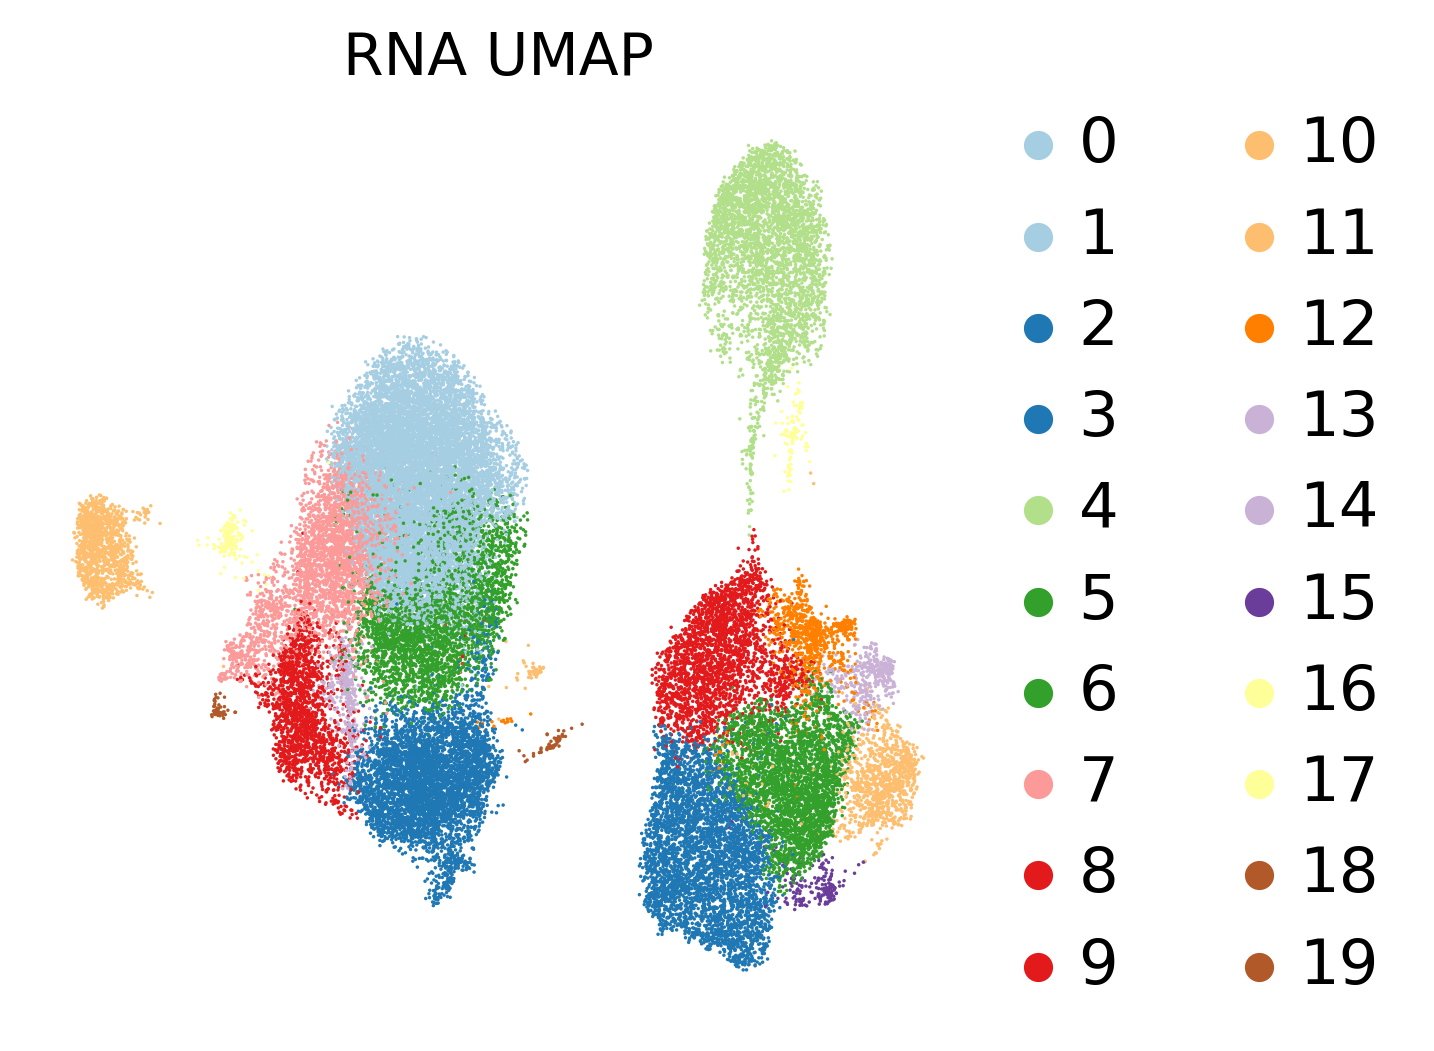

In [66]:
# Visualize
sc.pl.umap(adata, color='leiden', title='RNA UMAP',palette='Paired',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

In [67]:
dc.run_ora(mat=adata, net=markers, source='cell_type', target='genesymbol', min_n=3, verbose=True,use_raw=False)

Running ora on mat with 42819 samples and 2920 targets for 110 sources.


100%|██████████| 42819/42819 [00:14<00:00, 2866.89it/s]


In [68]:
adata.obsm['ora_estimate']

source        Acinar cells  Adipocytes  Alpha cells  Alveolar macrophages  \
G620_T_0         -0.000000    2.831320         -0.0             -0.000000   
G620_T_1         -0.000000    4.133376         -0.0             -0.000000   
G620_T_2         -0.000000    1.668984         -0.0             -0.000000   
G620_T_3         -0.000000    5.549448         -0.0             -0.000000   
G620_T_4         -0.000000    0.691822         -0.0              3.502345   
...                    ...         ...          ...                   ...   
G1003_T_9566     -0.000000    0.691822         -0.0             -0.000000   
G1003_T_9567      2.841681    7.063178         -0.0             -0.000000   
G1003_T_9568      1.244589    7.063178         -0.0             -0.000000   
G1003_T_9569     -0.000000    2.831320         -0.0             -0.000000   
G1003_T_9570      1.244589    7.063178         -0.0             -0.000000   

source        Astrocytes   B cells  B cells memory  B cells naive  Basophils  \
G620_T_0       11.031905 -0.000000        1.010908      -0.000000  -0.000000   
G620_T_1        9.251932  1.041538       -0.000000      -0.000000  -0.000000   
G620_T_2        4.444250 -0.000000       -0.000000      -0.000000   0.886029   
G620_T_3       11.031905 -0.000000        1.010908      -0.000000  -0.000000   
G620_T_4        0.760576  3.985897        1.010908       4.918807   0.886029   
...                  ...       ...             ...            ...        ...   
G1003_T_9566    4.444250  1.041538        3.883490       3.401638   2.078686   
G1003_T_9567    7.555012 -0.000000       -0.000000       0.865296   2.078686   
G1003_T_9568    9.251932 -0.000000        1.010908      -0.000000   5.013250   
G1003_T_9569    7.555012 -0.000000       -0.000000      -0.000000  -0.000000   
G1003_T_9570   14.820526 -0.000000       -0.000000      -0.000000   0.886029   

source        Bergmann glia  ...  Sebocytes  Sertoli cells  \
G620_T_0          10.349163  ...  -0.000000        0.95602   
G620_T_1          10.349163  ...  -0.000000        0.95602   
G620_T_2           5.013250  ...  -0.000000       -0.00000   
G620_T_3          10.349163  ...  -0.000000        0.95602   
G620_T_4          -0.000000  ...   1.244589       -0.00000   
...                     ...  ...        ...            ...   
G1003_T_9566       3.469896  ...  -0.000000       -0.00000   
G1003_T_9567       6.683526  ...   1.244589       -0.00000   
G1003_T_9568      12.328542  ...  -0.000000       -0.00000   
G1003_T_9569      10.349163  ...  -0.000000       -0.00000   
G1003_T_9570      12.328542  ...  -0.000000        0.95602   

source        Smooth muscle cells    T cells  T helper cells  \
G620_T_0                -0.000000   0.614009       -0.000000   
G620_T_1                 0.745716   0.614009        1.195001   
G620_T_2                -0.000000   0.614009       -0.000000   
G620_T_3                -0.000000  -0.000000       -0.000000   
G620_T_4                -0.000000  24.266088        1.195001   
...                           ...        ...             ...   
G1003_T_9566             0.745716   6.507463        1.195001   
G1003_T_9567             0.745716   0.614009       -0.000000   
G1003_T_9568            -0.000000  -0.000000       -0.000000   
G1003_T_9569            -0.000000  -0.000000       -0.000000   
G1003_T_9570            -0.000000  -0.000000       -0.000000   

source        T regulatory cells  Tanycytes  Taste receptor cells  Thymocytes  \
G620_T_0                1.444005   2.841681                  -0.0   -0.000000   
G620_T_1                1.444005   4.682424                  -0.0    1.150805   
G620_T_2               -0.000000   6.729366                  -0.0   -0.000000   
G620_T_3               -0.000000   4.682424                  -0.0   -0.000000   
G620_T_4                1.444005   1.244589                  -0.0    6.257189   
...                          ...        ...                   ...         ...   
G1003_T_9566            1.444005 

In [69]:
adata.obsm['ora_estimate'].columns

Index(['Acinar cells', 'Adipocytes', 'Alpha cells', 'Alveolar macrophages',
       'Astrocytes', 'B cells', 'B cells memory', 'B cells naive', 'Basophils',
       'Bergmann glia',
       ...
       'Sebocytes', 'Sertoli cells', 'Smooth muscle cells', 'T cells',
       'T helper cells', 'T regulatory cells', 'Tanycytes',
       'Taste receptor cells', 'Thymocytes', 'Tuft cells'],
      dtype='object', name='source', length=110)

In [70]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')
acts

AnnData object with n_obs × n_vars = 42819 × 110
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'leiden'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'majority_voting_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony', 'ora_estimate', 'ora_pvals'

In [71]:
mean_enr = dc.summarize_acts(acts, groupby='leiden', min_std=1)
mean_enr

Adipocytes  Astrocytes  B cells memory  B cells naive  Bergmann glia  \
0     1.139124    0.767260        2.071592       2.398035       0.342444   
1     0.994964    1.446403        1.906671       2.099271       0.738001   
10    0.674411    2.200278        2.471285       4.158386       1.513095   
11    3.763289    6.550022        0.345551       0.030690       8.284922   
12    1.632424    4.486502        0.590144       1.018523       5.264524   
13    1.502334    2.767936        0.358911       0.299262       3.175858   
14    0.890089    3.030274        0.982153       1.128277       1.779823   
15    2.718633    7.363615        0.338654       0.036134       9.738859   
16    0.719846    1.563656        2.781489       4.119397       1.009083   
17    2.709213    7.681002        0.134100       0.017659       8.566635   
18    0.446221    2.786777        0.750884       1.197118       2.866899   
19    2.107863    1.876981        4.041299       5.380205       1.245579   
2     0.813623    2.263040        1.695960       2.080513       2.193374   
3     5.104921   11.678173        0.105115       0.025306      11.115312   
4     0.301175    3.307317        0.100808       0.156010       2.019164   
5     1.490760    1.898400        1.457640       1.712518       1.422673   
6     4.483012    9.757080        0.469871       0.070197      11.604109   
7     1.303663    2.821929        1.344615       1.648557       1.744591   
8     3.028464    5.282466        0.132158       0.196665       5.632038   
9     0.947823    2.926213        1.105760       1.478200       2.134032   

    Dendritic cells  Endothelial cells  Enteric glia cells  Eosinophils  \
0         10.581033           2.633617            0.224201     2.379748   
1         12.364919           2.532285            0.516836     2.716083   
10         4.922052           2.491437            0.415532     2.377085   
11         1.709498           3.482093            2.479112     0.033684   
12         2.427063           3.068538            2.279999     0.230894   
13         1.317419           1.635235            1.579256     0.132300   
14        15.737267           2.564612            1.252152     2.939938   
15         2.004735           4.549345            3.367638     0.156122   
16        13.517745           2.471342            0.199229     3.305453   
17         2.382445           6.415505            3.020576     0.000000   
18         3.754930          15.177029            0.721271     0.638680   
19         7.525365           2.767906            0.260817     0.914177   
2          9.718451           2.563936            0.743191     1.763487   
3          2.273452           6.350461            3.685807     0.017333   
4          1.827657           5.224410            2.378976     0.040921   
5         13.039374           2.145840            0.998573     2.161865   
6          2.200032           4.086810            3.164005     0.019860   
7         17.543484           3.333520            0.978964     2.835508   
8          2.009608           4.994407            2.125331     0.035640   
9         12.811557           4.102005            0.929027     2.068075   

    Ependymal cells  ...  Oligodendrocytes  Plasma cells  \
0          0.248766  ...          0.371648      3.030526   
1          0.441165  ...          0.478255      2.864203   
10         0.541277  ...          0.411341      2.172307   
11         3.238870  ...          1.062257      0.274982   
12         2.964614  ...          1.353457      0.992817   
13         1.650862  ...          1.121839      0.742919   
14         0.867540  ...          0.501968      1.845958   
15         2.910837  ...          1.946606      0.252316   
16         0.160295  ...          0.328285      3.001503   
17         4.026724  ...         18.252342      0.207188   
18         1.663079  ...          0.627433      1.432347   
19         0.358248  ...          0.737900      6.157411   
2          1.474319  ...          0.633711      1.3

In [72]:
sns.clustermap(mean_enr, xticklabels=mean_enr.columns, cmap='viridis')
plt.show()

In [73]:
annotation_dict = dc.assign_groups(mean_enr)
annotation_dict

{'0': 'Macrophages',
 '1': 'Macrophages',
 '10': 'T cells',
 '11': 'Gamma delta T cells',
 '12': 'Bergmann glia',
 '13': 'Neural stem/precursor cells',
 '14': 'Dendritic cells',
 '15': 'Bergmann glia',
 '16': 'T cells',
 '17': 'Oligodendrocytes',
 '18': 'Endothelial cells',
 '19': 'Plasmacytoid dendritic cells',
 '2': 'Dendritic cells',
 '3': 'Astrocytes',
 '4': 'Oligodendrocytes',
 '5': 'Dendritic cells',
 '6': 'Bergmann glia',
 '7': 'Dendritic cells',
 '8': 'Fibroblasts',
 '9': 'Dendritic cells'}

... storing 'cell_type' as categorical


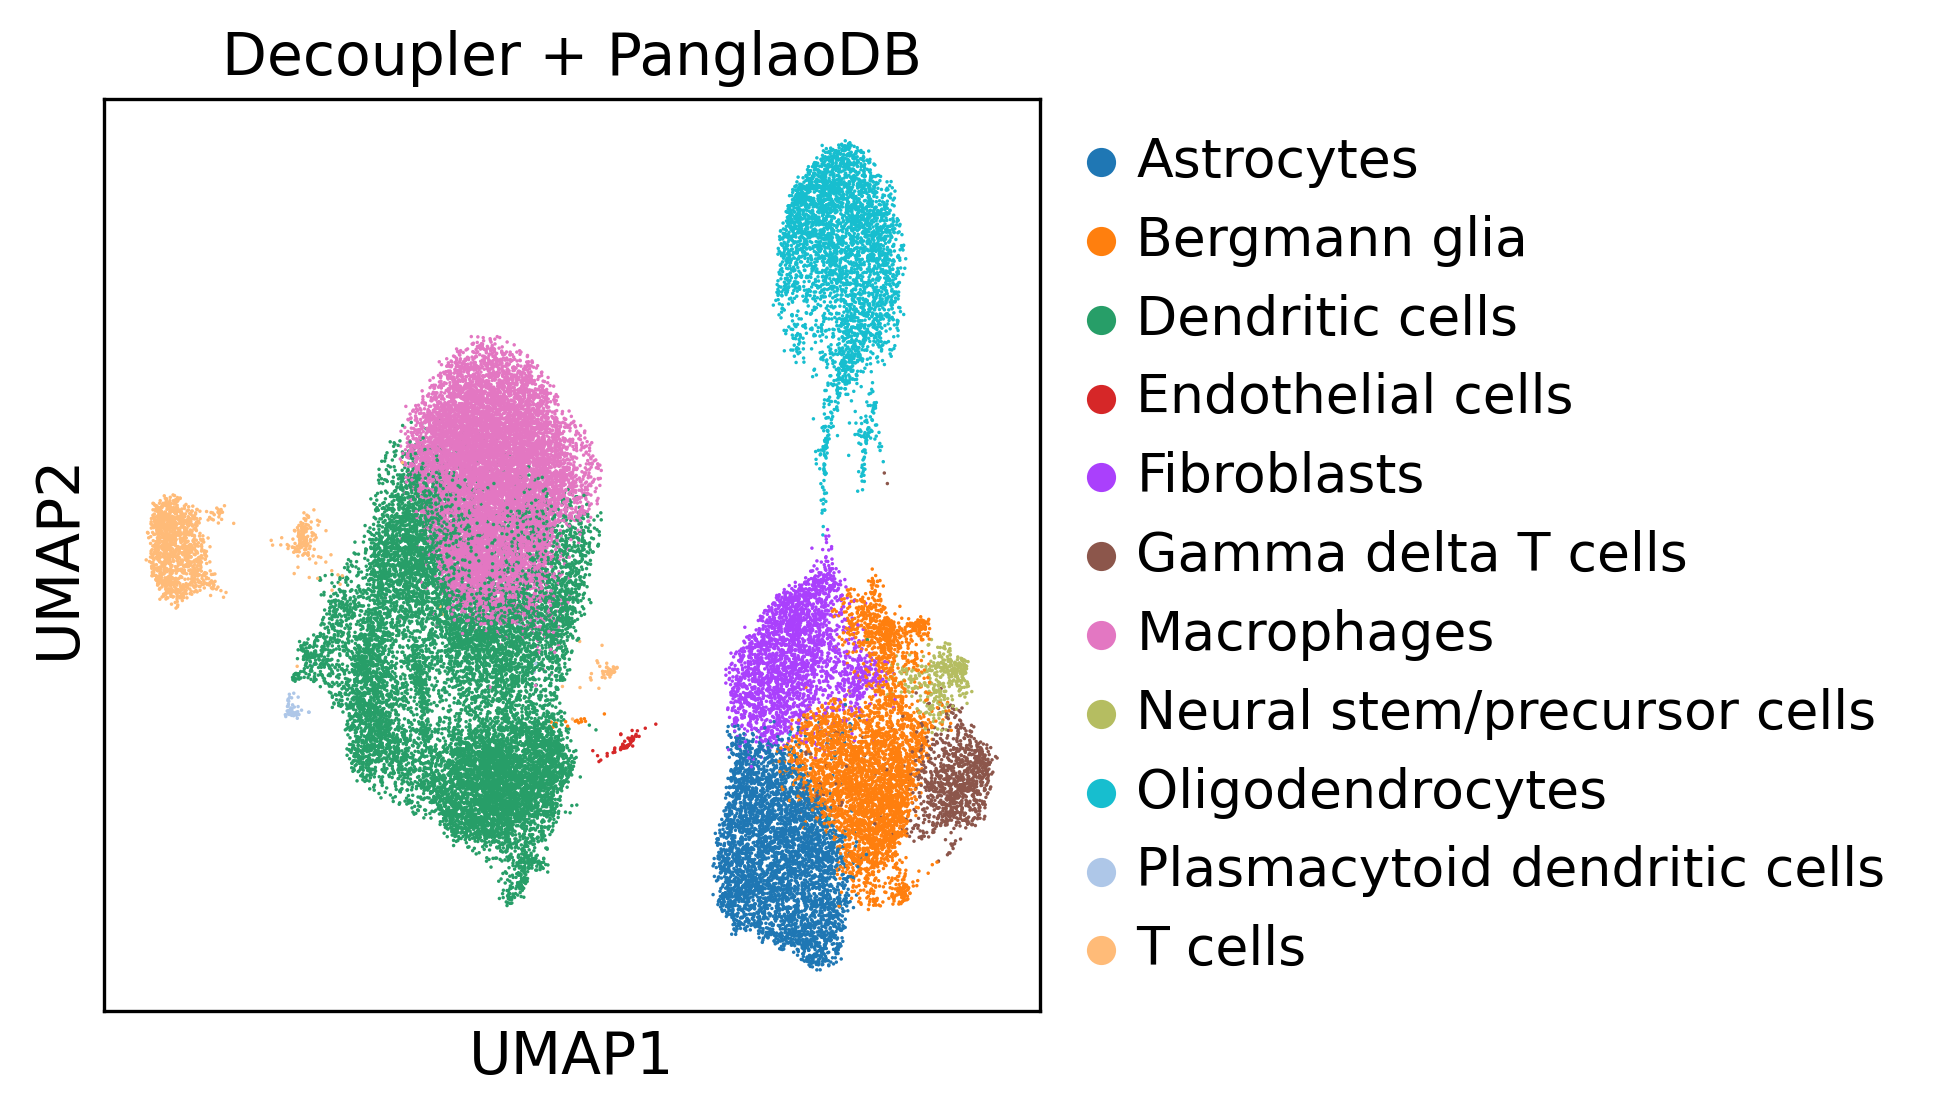

In [74]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type',title='Decoupler + PanglaoDB')

In [77]:
adata = adata.raw.to_adata()

In [ ]:
adata.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Part1_R_SCP503_PMID35122077.h5ad")